<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Feudal_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trello:

### Done
* Minimo viable visual **CHK**
  * particionar matriz gobernador **CHK**
  * particionar matriz señor **CHK**
  * particionar matriz vasallo **CHK**
  * Conectar el update **CHK**
* Actualizar valores por etapa (loyalties y army) **CHK**
  * Actualizar loyalties segun decay rate **CHK**
  * Actualizar armies segun grow rate **CHK**
* arreglar BUG: finds deben funcionar con config no con all_list **CHK**

### To Do
* Generar reglas
  * segun army_value semi chk (craneada pero no implementada)
    * vasallo ataca segun fuerza de neighbours: attack lowest army value neighbour if im the strongest of the neighbour (neighbour is all but self)
    y si conquista le pasa su id a ese cuadro (que pasa con army value? adopta porcion? pierde otro par)
  * segun loyalties
  * mixtas?
* Generar consecuencias:
  * que pasa cuando ataca 
* Hacer funcion generadora de condiciones iniciales
  * generar vasallos
  * asignar algunos vasallos contiguos a señor
  * asignar algunos señores contiguos a gobernador


In [0]:
import matplotlib
from pylab import *
from IPython import display
import time
import numpy as np
from random import uniform

In [0]:
# Parameters

vassal_grid_size = 5 # n x n
lord_grid_size = vassal_grid_size - 2
governor_grid_size = lord_grid_size - 1

initial_army_level_min, initial_army_level_max = 0.1, 2  # starts low, [1, 10]
initial_loyalty_value = 1.0 # starts at max, [0.0, 1.0]
army_growth_rate = 0.1
loyalty_decay_rate = 0.01

In [0]:
# Classes


class Vassal:  # Vasallo

  def __init__(self, id_, initial_army_level, initial_loyalties_up):
    self.id_ = id_
    self.army_value = initial_army_level
    self.loyalties_up = initial_loyalties_up #dict: {L1: loyalty_value1, L2: l_v2}

  def __repr__(self):
    return "Vassal{} a_v:{} l_up:{}".format(self.id_, self.army_value, self.loyalties_up)


class Lord:  # Señor

  def __init__(self, id_, initial_loyalties_up, initial_loyalties_down):
    self.id_ = id_
    self.loyalties_up = initial_loyalties_up  # dict: {G1: loyalty_value1, G2: l_v2}
    self.loyalties_down = initial_loyalties_down  # dict: {V1: loyalty_value1, V2: l_v2}
    
  def army_value(self):
    """Function to calculate army value of Lord given its loyalties down"""
    pass

  def __repr__(self):
    return "Lord{} l_down:{}".format(self.id_, self.loyalties_down)


class Governor:  # Gobernador

  def __init__(self, id_, initial_loyalties_down):
    self.id_ = id_
    self.loyalties_down = initial_loyalties_down  # dict: {L1: loyalty_value1, L2: l_v2}
    
  def army_value(self):
    """Function to calculate army value of Governor given its loyalties down"""
    pass

  def __repr__(self):
    return "Governor{} l_down:{}".format(self.id_, self.loyalties_down)

In [0]:
#Auxiliar functions

def connect_down(A, B, value=initial_loyalty_value):
  """Connects A down to B. A will have a loyalties_down pointing to B.
  B will have a loyalties_up pointing to A"""
  A.loyalties_down[B.id_] = value
  B.loyalties_up[A.id_] = value

def connect_all():
  """ Given a grid size, this generates random valid starting conditions for the connections"""
  pass

def print_connections(vassal_config, lord_config, governor_config):
    print("Vassal Config:")
    print(vassal_config)
    print("")
    print("Lord Config:")
    print(lord_config)
    print("")
    print("Governor Config:")
    print(governor_config)
    print("")

def find_lord_of_vassal(vassal):
  """ Given a vassal object, returns the lord object connected with him """
  lord_id = list(vassal.loyalties_up.keys())[0]  # id of first lord connected
  target_lord = None
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      if lord_config[x,y].id_ == lord_id:
        target_lord = lord_config[x,y]
        return target_lord
  if target_lord == None:
    raise ValueError("Vassal's lord not found in lord_config")

def find_governor_of_vassal(vassal):
  """ Given a vassal object, returns the governor object connected with him through a lord"""
  lord = find_lord_of_vassal(vassal)
  governor_id = list(lord.loyalties_up.keys())[0]  # id of first governor connected
  target_governor = None
  for x in range(governor_grid_size):
    for y in range(governor_grid_size):
      if governor_config[x, y].id_ == governor_id:
        target_governor = governor_config[x, y]
        return target_governor
  if target_governor == None:
    raise ValueError("Vassal's governor not found in governor_config")

def find_vassal_by_id(attacker_id): #cuidao que este es con nextconfig
  for x in range(vassal_grid_size):
    for y in range(vassal_grid_size):
      if attacker_id == vassal_nextconfig[x,y].id_:
        return vassal_nextconfig[x,y]


In [0]:
# backend

def initialize():
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig, all_vassals, all_lords, all_governors


    #initialize vassal level
    vassal_config = np.zeros([vassal_grid_size, vassal_grid_size], dtype=type(Vassal(None, 1, {})))

    id_counter = 1
    for x in range(vassal_grid_size):
      for y in range(vassal_grid_size):
        initial_army_level = round(uniform(initial_army_level_min, initial_army_level_max), 3)
        new_vassal = Vassal(id_counter, initial_army_level, {})
        vassal_config[x, y] = new_vassal
        id_counter += 1

    vassal_nextconfig = np.zeros([vassal_grid_size, vassal_grid_size], dtype=type(Vassal(None, 1, {})))

    #initialize lord level
    lord_config = np.zeros([lord_grid_size, lord_grid_size], dtype=type(Lord(None, {}, {})))

    id_counter = 1
    for x in range(lord_grid_size):
      for y in range(lord_grid_size):
        new_lord = Lord(id_counter, {}, {})
        lord_config[x, y] = new_lord
        id_counter += 1

    lord_nextconfig = np.zeros([lord_grid_size, lord_grid_size], dtype=type(Lord(None, {}, {})))

    #initialize governor level
    governor_config = np.zeros([governor_grid_size, governor_grid_size], dtype=type(Governor(None, {})))

    id_counter = 1
    for x in range(governor_grid_size):
      for y in range(governor_grid_size):
        new_governor = Governor(id_counter, {})
        governor_config[x, y] = new_governor
        id_counter += 1

    governor_nextconfig = np.zeros([governor_grid_size, governor_grid_size], dtype=type(Governor(None, {})))

    #connect all levels (random initial condition (WIP))
    #connect_all()
    
    #connect all levels (deterministic initial condition)
    #connect govs
    #1st gov
    connect_down(governor_config[0,0], lord_config[0, 0])
    connect_down(governor_config[0,0], lord_config[1, 0])
    #2nd gov
    connect_down(governor_config[0,1], lord_config[0, 1])
    connect_down(governor_config[0,1], lord_config[0, 2])
    #3rd gov
    connect_down(governor_config[1,0], lord_config[1, 1])
    connect_down(governor_config[1,0], lord_config[1, 2])
    connect_down(governor_config[1,0], lord_config[2, 2])
    #4th gov
    connect_down(governor_config[1,1], lord_config[2, 0])
    connect_down(governor_config[1,1], lord_config[2, 1])
    
    #connect lords
    #1st lord
    connect_down(lord_config[0,0], vassal_config[0, 0])
    connect_down(lord_config[0,0], vassal_config[1, 0])
    connect_down(lord_config[0,0], vassal_config[0, 1])
    #2do lord
    connect_down(lord_config[0,1], vassal_config[0, 2])
    connect_down(lord_config[0,1], vassal_config[1, 2])
    connect_down(lord_config[0,1], vassal_config[0, 3])
    #3rd lord
    connect_down(lord_config[0,2], vassal_config[1, 3])
    connect_down(lord_config[0,2], vassal_config[0, 4])
    connect_down(lord_config[0,2], vassal_config[1, 4])
    connect_down(lord_config[0,2], vassal_config[2, 4])
    #4th lord
    connect_down(lord_config[1,0], vassal_config[2, 0])
    connect_down(lord_config[1,0], vassal_config[1, 1])
    connect_down(lord_config[1,0], vassal_config[2, 1])
    #5th lord
    connect_down(lord_config[1,1], vassal_config[2, 2])
    connect_down(lord_config[1,1], vassal_config[3, 2])
    connect_down(lord_config[1,1], vassal_config[2, 3])
    #6th lord
    connect_down(lord_config[1,2], vassal_config[3, 3])
    connect_down(lord_config[1,2], vassal_config[3, 4])
    connect_down(lord_config[1,2], vassal_config[4, 4])
    #7th lord
    connect_down(lord_config[2,0], vassal_config[3, 0])
    connect_down(lord_config[2,0], vassal_config[4, 0])
    #8th lord
    connect_down(lord_config[2,1], vassal_config[3, 1])
    connect_down(lord_config[2,1], vassal_config[4, 1])
    #9th lord
    connect_down(lord_config[2,2], vassal_config[4, 2])
    connect_down(lord_config[2,2], vassal_config[4, 3])

    # print_connections(vassal_config, lord_config, governor_config)


def observe(ca_level="lord", color_map="viridis"):
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig
    cla()
    if ca_level == "vassal":  # plot vassal level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          aux_config[x,y] = vassal_config[x,y].id_ #cambia instancia por id
      imshow(aux_config, vmin = 0, vmax = vassal_grid_size * vassal_grid_size, cmap = color_map)

    if ca_level == "lord":  # plot lord level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          aux_config[x,y] = find_lord_of_vassal(vassal_config[x,y]).id_  # cambia instancia de vassal por id del primer lord conectado
      imshow(aux_config, vmin = 0, vmax = vassal_grid_size * vassal_grid_size, cmap = color_map)

    if ca_level == "governor":  # plot governor level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          aux_config[x,y] = find_governor_of_vassal(vassal_config[x,y]).id_  # cambia instancia de vassal por id del primer lord conectado
      imshow(aux_config, vmin = 0, vmax = vassal_grid_size * vassal_grid_size, cmap = color_map)

    #print_connections(vassal_config, lord_config, governor_config)

def update():
  """ First we update army_value and loyalties for all vassals/lords/govs, then we generate decisions/actions for gov,lord,vassal """
  global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig

  vassal_hitmap = {}  # {attacker_id: target_id}
  # iterate through vassal grid
  for x in range(vassal_grid_size):
    for y in range(vassal_grid_size):
      current_vassal = vassal_config[x, y]
      updated_army_value = round(current_vassal.army_value * (1 + army_growth_rate), 3)  # in each step army value grows by army_growth_rate
      updated_loyalties = {k: v * (1 - loyalty_decay_rate) for k, v in current_vassal.loyalties_up.items()}  # in each step loyalty decays by loyalty_decay_rate
      vassal_nextconfig[x, y] = Vassal(current_vassal.id_, updated_army_value, updated_loyalties)

      # iterate thorugh neighbourhood
      neighbours_army_values = {}  # if it has the same neighbour more than once, values are added
      for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
          try:
            current_neighbour = vassal_config[x + dx, y + dy]
            if current_neighbour.id_ != current_vassal.id_:  # skip if self
              try:
                neighbours_army_values[current_neighbour.id_] += current_neighbour.army_value
              except KeyError: #first time entering value
                neighbours_army_values[current_neighbour.id_] = current_neighbour.army_value
          except IndexError:  # vassal is in border of map
            continue
      
      if len(neighbours_army_values) > 0 and current_vassal.army_value >= max(neighbours_army_values.values()):  # if stronger than neighbours
        target_vassal_id = min(neighbours_army_values.keys(), key=(lambda k: neighbours_army_values[k]))  # attacks weakest neighbour
        vassal_hitmap[current_vassal.id_] = target_vassal_id
  print("Hitmap")
  print(vassal_hitmap)
  #raise ValueError
  #after all attacks are checked (all vassals are in nextconfig)
  for attacker_id, target_id in vassal_hitmap.items():
    attacker = find_vassal_by_id(attacker_id)
    try:
      target = find_vassal_by_id(target_id) #ESTE target PODRIA NO SER SU VECINO!! solo otro con ese mismo id, podriamos retornar todos los que hagan match con ese id en el find
      target.id_ = attacker_id
      target.loyalties_up = attacker.loyalties_up #QUE ARMY VALUE TIENE EL ATACADO???
    except AttributeError: #revisar esto, porque no lo ecnuentra? ya conquistado? ADEMAS: BUG: LOS ATAQUES CRUZAN FONTERAS DEL MAPA
      pass

  #iterate through lord grid
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      current_lord = lord_config[x, y]
      updated_loyalties_up = {k: v * (1 - loyalty_decay_rate) for k, v in current_lord.loyalties_up.items()}  # in each step loyalty decays by loyalty_decay_rate
      updated_loyalties_down = {k: v * (1 - loyalty_decay_rate) for k, v in current_lord.loyalties_down.items()}
      lord_nextconfig[x, y] = Lord(current_lord.id_, updated_loyalties_up, updated_loyalties_down)

  #iterate through governor grid
  for x in range(governor_grid_size):
    for y in range(governor_grid_size):
      current_governor = governor_config[x, y]
      updated_loyalties_down = {k: v * (1 - loyalty_decay_rate) for k, v in current_governor.loyalties_down.items()}
      governor_nextconfig[x, y] = Governor(current_governor.id_, updated_loyalties_down)

  

  vassal_config, vassal_nextconfig = vassal_nextconfig, vassal_config
  lord_config, lord_nextconfig = lord_nextconfig, lord_config
  governor_config, governor_nextconfig = governor_nextconfig, governor_config

Hitmap
{9: 5, 17: 23, 24: 19}


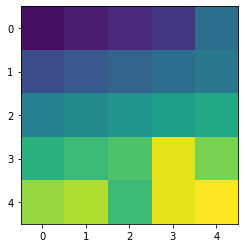

Hitmap
{9: 4, 17: 22, 24: 17}


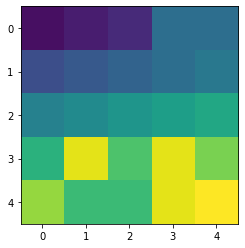

Hitmap
{9: 3, 24: 17}


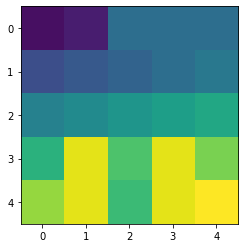

Hitmap
{9: 14, 24: 17}


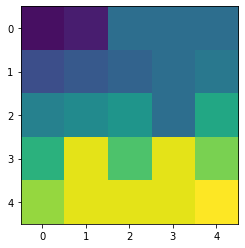

Hitmap
{9: 8, 24: 25}


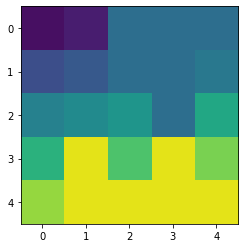

Hitmap
{9: 13, 24: 18}


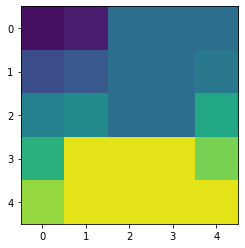

Hitmap
{9: 10, 24: 20}


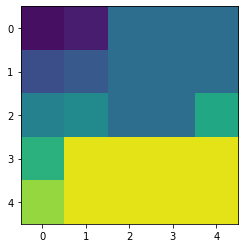

Hitmap
{9: 15, 24: 9}


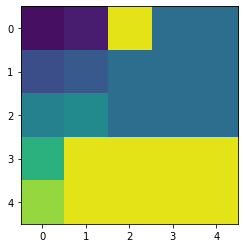

Hitmap
{9: 24, 24: 11}


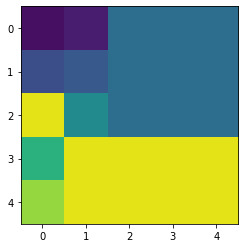

Hitmap
{24: 16}


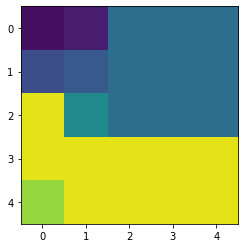

In [6]:
#main

# Simulate and plot results
initialize()
observe("vassal", "viridis")
for t in range(10):
    update()
    observe("vassal", "viridis")
    #display.clear_output(wait=True)
    #display.display(gcf())
    #time.sleep(0.1)
    #plt.close()
    plt.show()